In [3]:
import agnprocesses.cosmology as cosmology
import agnprocesses.synchro as synchro
import agnprocesses.ic as ic
import agnprocesses.spectra as spec
import agnprocesses.ebl as ebl
# import agnprocesses.pgamma as pgamma
# import agnprocesses.bh as bh
# import agnprocesses.gamma_gamma as gamma_gamma
###############################################################################
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

In [4]:
# Geometry, distance, magnetic field
z = 0.3365
doppler = 30.0  # Doppler blob factor
r_b = 5.598e+16 * u.cm  # blob radius
print("r_b = {:.3e}".format(r_b))
d_l = cosmology.luminosity_distance(z).to(u.cm)
print("d_l = {:.6e}".format(d_l))
b = 50.0 * u.mG  # 50 milligauss, you can use, e.g. u.kG, u.mkG and so on
print("B = {:.6e}".format(b))

norm_e = 7.959e+39 * u.eV**(-1)
print("norm_e = {:.3e}".format(norm_e))
gamma1 = 1.9
gamma2 = 4.5
print("gamma1 = {:.2f}, gamma2 = {:.2f}".format(gamma1, gamma2))
e_br = 9.0e+09 * u.eV
e_min_e = 5.0e+06 * u.eV
e_max_e = 1.0e+12 * u.eV
print("e_break = {:.3e}, e_min = {:.3e}, e_max = {:.3e}".format(
    e_br, e_min_e, e_max_e
))
e_e = np.logspace(np.log10(e_min_e.to(u.eV).value),
                    np.log10(e_max_e.to(u.eV).value), 100) * u.eV

# synchrotron
nu = np.logspace(7, 18.0, 100) * u.Hz
synchro_spec = synchro.derishev_synchro_spec(nu, b,
                                                norm=norm_e,
                                                spec_law='broken_power_law',
                                                gamma1=gamma1,
                                                gamma2=gamma2,
                                                en_break=e_br,
                                                en_min=e_min_e,
                                                en_max=e_max_e)
synchro_epsilon = (const.h * nu).to(u.eV)
synchro_density = (synchro_spec / (4.0 / 3.0 * np.pi * r_b**2 * const.c.to(
    u.cm / u.s)
)).to(u.eV**(-1) * u.cm**(-3))
field = spec.create_2column_table(synchro_epsilon,
                                    synchro_density)
synchro_e = synchro_epsilon / (1.0 + z) * doppler
synchro_sed = synchro_epsilon**2 * synchro_spec
synchro_sed = synchro_sed * doppler**4 / (4.0 * np.pi * d_l**2)

# IC
ic_e = np.logspace(0, 11.5, 100) * u.eV
ic_spec = ic.inverse_compton_spec(ic_e,
                                    field,
                                    norm=norm_e,
                                    spec_law='broken_power_law',
                                    gamma1=gamma1,
                                    gamma2=gamma2,
                                    en_break=e_br,
                                    en_min=e_min_e,
                                    en_max=e_max_e,
                                    background_photon_energy_unit=synchro_epsilon.unit,
                                    background_photon_density_unit=synchro_density.unit)
ic_sed = ic_e**2 * ic_spec
ic_e *= doppler / (1.0 + z)
ic_sed *= doppler**4 / (4.0 * np.pi * d_l**2)
print("ic_sed.unit = {}".format(ic_sed.unit))

summ_e, summ_sed = spec.summ_spectra(synchro_e, synchro_sed, ic_e, ic_sed,
                                        nbin=100)
summ_filter = (summ_e < 2.0 * u.TeV)  # filter to plot only up to 2 TeV
summ_e = summ_e[summ_filter]
summ_sed = summ_sed[summ_filter]

# Data from Science https://science.sciencemag.org/content/361/6398/eaat1378 : gamma-rays
from agnprocesses.data_files import DATA_DIR
data = np.loadtxt(DATA_DIR / 'science-2017_gamma_flare_electromagnetic_component_v2.txt')
data_en = data[:, 0]
data_sed = data[:, 1]
data_low = data[:, 3]
data_up = data[:, 2]
yerr = [data_low, data_up]


r_b = 5.598e+16 cm
d_l = 5.643309e+27 cm
B = 5.000000e+01 mG
norm_e = 7.959e+39 1 / eV
gamma1 = 1.90, gamma2 = 4.50
e_break = 9.000e+09 eV, e_min = 5.000e+06 eV, e_max = 1.000e+12 eV
ic_sed.unit = eV / (cm2 s)


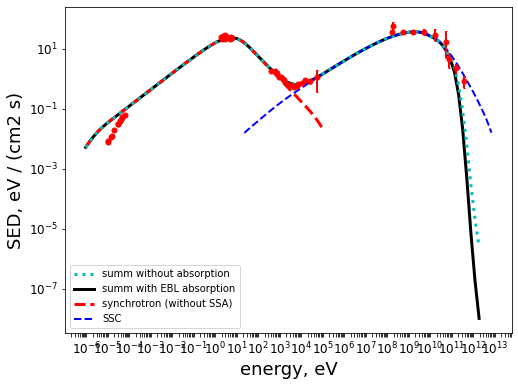

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(
    summ_e, summ_sed,
    marker=None,
    linestyle=':',
    linewidth=3,
    color='c',
    zorder=100,
    label='summ without absorption'
)
# EBL absorption: ON
summ_sed = summ_sed * np.exp(-ebl.tau_gilmore(summ_e, z))
plt.plot(
    summ_e, summ_sed,
    marker=None,
    linestyle='-',
    linewidth=3,
    color='k',
    label='summ with EBL absorption'
)
plt.plot(
    synchro_e, synchro_sed,
    marker=None,
    linestyle='--',
    linewidth=3,
    color='r',
    label='synchrotron (without SSA)'
)
plt.plot(
    ic_e, ic_sed,
    marker=None,
    linewidth=2,
    linestyle='--',
    color='b',
    label='SSC'
)
plt.errorbar(data_en, data_sed,
                yerr=yerr, xerr=None, fmt='o', linewidth=0, elinewidth=2,
                capsize=1, barsabove=False, markersize=5,
                errorevery=1, capthick=1, color='r', zorder=100.0)
plt.xlabel('energy, ' + str(ic_e.unit), fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel('SED, ' + str(ic_sed.unit), fontsize=18)
plt.yticks(fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_locator(ticker.LogLocator(
    base=10.0, numticks=22, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9]))
# ax.set_xlim(1.0e-02, 1.0e+17)
# ax.set_ylim(1.0e-02, 1.0e+03)
# ax.grid()
# ax.grid()
# fig.savefig('test_figures/exponential_cutoff_compare_with_Derishev_fig4a.pdf')
# plt.legend()
plt.legend()
plt.show()